<a href="https://colab.research.google.com/github/LolaSM/neck-pain/blob/main/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jun 27 15:04:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
print("Versión de TF:", tf.__version__)
print("GPUs visibles para TF:", tf.config.list_physical_devices('GPU'))

Versión de TF: 2.18.0
GPUs visibles para TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [14]:
# Reproducibilidad
tf.keras.utils.set_random_seed(42)

url ='https://raw.githubusercontent.com/LolaSM/neck-pain/refs/heads/main/tablagrupos_AB_raw.csv'
df = pd.read_csv(url)
# Verificamos las columnas
print(df.columns)
df.head()

Index(['paciente_columna', 'grupo_columna', 'tiempo', 'posicionX', 'posicionY',
       'posicionZ', 'anguloEulerX', 'anguloEulerY', 'anguloEulerZ'],
      dtype='object')


,paciente_columna,grupo_columna,tiempo,posicionX,posicionY,posicionZ,anguloEulerX,anguloEulerY,anguloEulerZ
0,1,A,56466.6141,0.1376,-0.19134,0.18056,-80.576508,40.16388,-26.151448
1,1,A,56486.5546,0.1376,-0.19134,0.18056,-80.576508,40.16388,-26.151448
2,1,A,56506.3472,0.0806,-0.13934,0.14656,-84.195995,37.00198,-24.848048
3,1,A,56526.7568,0.0806,-0.13934,0.14656,-84.195995,37.00198,-24.848048
4,1,A,56547.5340,0.0806,-0.13934,0.14656,-84.195995,37.00198,-24.848048


In [15]:
# --- parámetros principales ---
WIN   = 256        # longitud de la ventana (timesteps) 5s
STEP  = 128        # desplazamiento;  solape 50 % (2,5s)
MIN_L = WIN        # ignora pacientes más cortos que la ventana
#MAX_W = 200        # (opcional) tope de ventanas por paciente para no inflar memoria

feature_cols = ['posicionX','posicionY','posicionZ',
                'anguloEulerX','anguloEulerY','anguloEulerZ']
label_map = {'A':0, 'B':1}

windows      = []    # (total_windows, WIN, 6)
window_labels= []    # 1 label por ventana
window_pids  = []    # identificador paciente por ventana

for pid, g in df.groupby('paciente_columna'):
    g   = g.sort_values('tiempo')
    seq = g[feature_cols].values.astype('float32')
    y   = label_map[g['grupo_columna'].iloc[0]]

    L   = len(seq)
    if L < MIN_L:                      # muy pocos pasos → descartamos
        continue

    # --- recorre la señal a saltos STEP ---
    n_added = 0
    for start in range(0, L - WIN + 1, STEP):
        win = seq[start : start + WIN]
        windows.append(win)
        window_labels.append(y)
        window_pids.append(pid)
        n_added += 1
        #if n_added >= MAX_W:   # límite opcional
            #break
windows       = np.stack(windows)                 # (Nw, WIN, 6)
window_labels = np.array(window_labels)           # (Nw,)
window_pids   = np.array(window_pids)             # (Nw,)

print("Ventanas generadas:", windows.shape)
print("Ejemplo   X:", windows[0].shape)

Ventanas generadas: (2779, 256, 6)
Ejemplo   X: (256, 6)


In [16]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

# ---------- 90 % train  · 10 % test ----------
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(windows, window_labels, groups=window_pids))

X_train, X_test = windows[train_idx], windows[test_idx]
y_train, y_test = window_labels[train_idx], window_labels[test_idx]
pid_train, pid_test = window_pids[train_idx], window_pids[test_idx]

# ---------- 10 % de los pacientes de train → VALIDACIÓN ----------
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
train_idx2, val_idx = next(gss_val.split(X_train, y_train, groups=pid_train))

X_val,   y_val,   pid_val   = X_train[val_idx],   y_train[val_idx],   pid_train[val_idx]
X_train, y_train, pid_train = X_train[train_idx2], y_train[train_idx2], pid_train[train_idx2]

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)


Train: (1994, 256, 6)  Val: (196, 256, 6)  Test: (589, 256, 6)


In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [20]:
import tensorflow as tf
tf.keras.backend.clear_session()

WIN  = X_train.shape[1]        # 256
F    = X_train.shape[2]        # 6

def build_model():
    inp = tf.keras.Input(shape=(WIN, F))
    x   = tf.keras.layers.Bidirectional(
              tf.keras.layers.LSTM(32, recurrent_dropout=0.2))(inp)
    #x   = tf.keras.layers.Dropout(0.2)(x)# probar sin dropout
    x   = tf.keras.layers.LayerNormalization()(x)
    x   = tf.keras.layers.Dense(16, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169 (43.63 KB)

 Trainable params: 11,169 (43.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
63/63 - 53s - 844ms/step - accuracy: 0.5361 - loss: 0.7163 - val_accuracy: 0.4745 - val_loss: 0.7066 - learning_rate: 1.0000e-04
Epoch 2/120
63/63 - 47s - 743ms/step - accuracy: 0.5446 - loss: 0.7000 - val_accuracy: 0.5306 - val_loss: 0.6847 - learning_rate: 1.0000e-04
Epoch 3/120
63/63 - 47s - 741ms/step - accuracy: 0.5527 - loss: 0.6902 - val_accuracy: 0.5765 - val_loss: 0.6709 - learning_rate: 1.0000e-04
Epoch 4/120
63/63 - 47s - 748ms/step - accuracy: 0.5657 - loss: 0.6823 - val_accuracy: 0.6071 - val_loss: 0.6602 - learning_rate: 1.0000e-04
Epoch 5/120
63/63 - 47s - 743ms/step - accuracy: 0.5737 - loss: 0.6749 - val_accuracy: 0.6276 - val_loss: 0.6512 - learning_rate: 1.0000e-04
Epoch 6/120
63/63 - 46s - 738ms/step - accuracy: 0.5838 - loss: 0.6692 - val_accuracy: 0.6735 - val_loss: 0.6451 - learning_rate: 1.0000e-04
Epoch 7/120
63/63 - 47s - 749ms/step - accuracy: 0.5923 - loss: 0.6641 - val_accuracy: 0.6888 - val_loss: 0.6398 - learning_rate: 1.0000e-04
Epoch 8/120
6

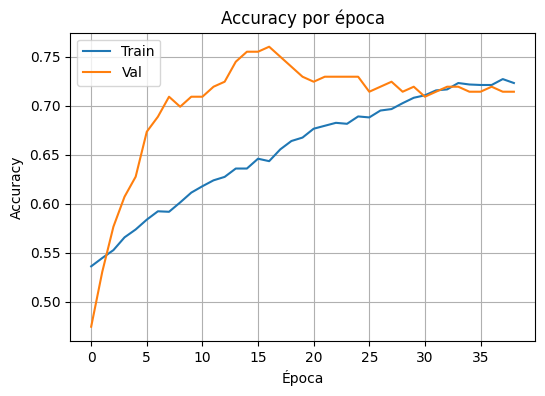

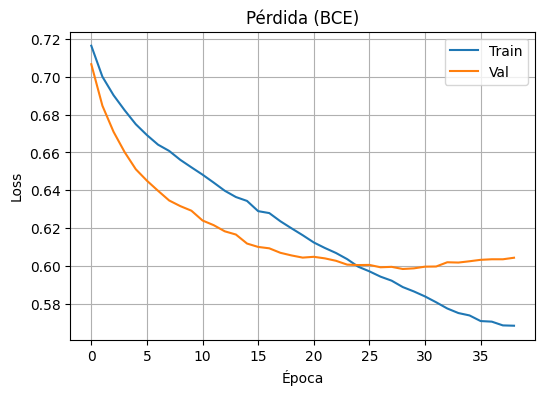

In [21]:
history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=120,
        batch_size=32,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)
        ],
        verbose=2
)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],     label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy por época'); plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],     label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Pérdida (BCE)'); plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()


In [22]:
# ---- predicciones de las ventanas del TEST ----
probs_test = model.predict(X_test, batch_size=64).ravel()

import pandas as pd
df_pred = pd.DataFrame({
    'pid':  pid_test,
    'prob': probs_test,
    'true': y_test
})

# ---- voto por paciente (media de probabilidades) ----
patient_prob = df_pred.groupby('pid')['prob'].mean()
patient_true = df_pred.groupby('pid')['true'].first()
patient_pred = (patient_prob >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc_pat = accuracy_score(patient_true, patient_pred)
print(f"\n  Accuracy por paciente (TEST): {acc_pat:.3f}")

cm = confusion_matrix(patient_true, patient_pred)
print("\nMatriz de confusión (paciente):\n", cm)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step

  Accuracy por paciente (TEST): 0.444

Matriz de confusión (paciente):
 [[1 7]
 [3 7]]
